Median Asking Rent - All Property Types

In [1]:
#Importing Needed Libraries
import pandas as pd

In [2]:
#Loading Rental Data 
median_rent_all = pd.read_csv('medianAskingRent_All.csv')
median_rent_all.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,...,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04
0,All Downtown,Manhattan,submarket,3200.0,3200.0,3025.0,3100.0,3100.0,3200.0,3195.0,3200.0,3400.0,3495.0,3450.0,3400.0,3365.0,3395.0,3300.0,3300.0,3395.0,3400.0,3395.0,3495.0,3625.0,3660.0,3550.0,3495.0,3450.0,3450.0,3500.0,3500.0,3580.0,3550.0,3500.0,3550.0,3650.0,3600.0,3675.0,3675.0,3550.0,...,3650.0,3700.0,3695.0,3714.0,3790.0,3725.0,3725.0,3700.0,3666.0,3664.0,3675.0,3644.0,3650.0,3750.0,3740.0,3760.0,3845.0,3800.0,3800.0,3800.0,3830.0,3800.0,3867.0,3800.0,3800.0,3860.0,3800.0,3948.0,4000.0,4093.0,4000.0,3995.0,4010.0,4095.0,4100.0,4056.0,4025.0,4093.0,4117.0,4000.0
1,All Midtown,Manhattan,submarket,2875.0,2800.0,2800.0,2850.0,2895.0,2950.0,3000.0,3000.0,3100.0,3100.0,3150.0,3150.0,3160.0,3198.0,3195.0,3200.0,3250.0,3300.0,3335.0,3300.0,3350.0,3375.0,3395.0,3350.0,3300.0,3250.0,3250.0,3320.0,3395.0,3395.0,3395.0,3400.0,3400.0,3400.0,3440.0,3450.0,3400.0,...,3470.0,3495.0,3468.0,3500.0,3500.0,3530.0,3500.0,3500.0,3500.0,3500.0,3350.0,3350.0,3387.0,3400.0,3392.0,3450.0,3500.0,3500.0,3500.0,3500.0,3511.0,3550.0,3508.0,3550.0,3500.0,3550.0,3550.0,3591.0,3642.0,3695.0,3714.0,3725.0,3710.0,3695.0,3738.0,3725.0,3738.0,3759.0,3800.0,3750.0
2,All Upper East Side,Manhattan,submarket,2460.0,2450.0,2400.0,2500.0,2550.0,2550.0,2595.0,2500.0,2595.0,2550.0,2500.0,2550.0,2500.0,2500.0,2450.0,2500.0,2600.0,2695.0,2650.0,2695.0,2795.0,2800.0,2800.0,2800.0,2700.0,2700.0,2695.0,2695.0,2695.0,2750.0,2700.0,2750.0,2850.0,2795.0,2850.0,2850.0,2795.0,...,2995.0,2995.0,2925.0,2950.0,2950.0,2950.0,2950.0,2900.0,2995.0,2950.0,2995.0,2990.0,2900.0,2895.0,2850.0,2850.0,2850.0,2900.0,2925.0,2900.0,2895.0,2995.0,2995.0,3000.0,3000.0,3000.0,2995.0,2995.0,3000.0,3050.0,3050.0,2995.0,3000.0,3100.0,3250.0,3300.0,3300.0,3295.0,3300.0,3250.0
3,All Upper Manhattan,Manhattan,submarket,1836.0,1800.0,1795.0,1800.0,1823.0,1850.0,1875.0,1850.0,1898.0,1875.0,1850.0,1850.0,1850.0,1800.0,1875.0,1895.0,1920.0,1950.0,1950.0,1976.0,1995.0,1985.0,1995.0,2000.0,2000.0,2000.0,2000.0,2000.0,1995.0,1963.0,2000.0,2050.0,2000.0,1995.0,2000.0,2000.0,1980.0,...,2350.0,2300.0,2295.0,2325.0,2350.0,2350.0,2395.0,2395.0,2353.0,2338.0,2250.0,2295.0,2262.0,2291.0,2300.0,2350.0,2375.0,2397.0,2425.0,2400.0,2350.0,2345.0,2300.0,2300.0,2299.0,2325.0,2365.0,2400.0,2450.0,2500.0,2500.0,2495.0,2429.0,2388.0,2350.0,2350.0,2381.0,2400.0,2475.0,2495.0
4,All Upper West Side,Manhattan,submarket,2895.0,2800.0,2750.0,2800.0,2800.0,2795.0,2800.0,2895.0,2995.0,3050.0,3000.0,2995.0,2995.0,3000.0,2950.0,3000.0,3000.0,3100.0,3100.0,3200.0,3250.0,3344.0,3388.0,3475.0,3300.0,3200.0,3045.0,3150.0,3200.0,3200.0,3250.0,3300.0,3325.0,3350.0,3350.0,3300.0,3200.0,...,3300.0,3315.0,3299.0,3300.0,3350.0,3385.0,3390.0,3395.0,3395.0,3400.0,3325.0,3350.0,3350.0,3295.0,3250.0,3295.0,3323.0,3350.0,3350.0,3335.0,3400.0,3400.0,3395.0,3400.0,3400.0,3360.0,3400.0,3479.0,3495.0,3478.0,3425.0,3532.0,3650.0,3630.0,3675.0,3595.0,3669.0,3600.0,3630.0,3500.0


In [3]:
#Melting DF into panel time series
df = median_rent_all.melt(id_vars=["areaName", "Borough", "areaType"], 
        var_name="Date", 
        value_name="Value")
df = df.sort_values(['areaName', 'Date'])
df

,areaName,Borough,areaType,Date,Value
0,All Downtown,Manhattan,submarket,2010-01,3200.0
198,All Downtown,Manhattan,submarket,2010-02,3200.0
396,All Downtown,Manhattan,submarket,2010-03,3025.0
594,All Downtown,Manhattan,submarket,2010-04,3100.0
792,All Downtown,Manhattan,submarket,2010-05,3100.0
...,...,...,...,...,...
23759,Woodstock,Bronx,neighborhood,2019-12,NaN
23957,Woodstock,Bronx,neighborhood,2020-01,1950.0
24155,Woodstock,Bronx,neighborhood,2020-02,1950.0
24353,Woodstock,Bronx,neighborhood,2020-03,1950.0


In [4]:
#Importing time series related libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [5]:
#Subsetting data for Redhook
redhook1 = median_rent_all.loc[median_rent_all['areaName'] == 'Red Hook']
redhook2 = redhook1.dropna(axis=1,how="all")
redhook3=redhook2.drop(['Borough','areaType'], axis=1)
redhook4 = redhook3.set_index(['areaName'])
redhook= redhook4.T
redhook =redhook.rename(columns={'areaName': 'year', 'Red Hook': 'median_rent_all'})
redhook = redhook.reset_index()
redhook['index'] =  pd.to_datetime(redhook['index'])
redhook = redhook.set_index(['index'])
redhook.head()

areaName,median_rent_all
index,
2010-01-01,2000.0
2010-09-01,2200.0
2010-10-01,2150.0
2010-11-01,1800.0
2010-12-01,1850.0


In [6]:
#Getting time means
time_means = redhook.resample('M').mean()
time_means

areaName,median_rent_all
index,
2010-01-31,2000.0
2010-02-28,NaN
2010-03-31,NaN
2010-04-30,NaN
2010-05-31,NaN
...,...
2019-12-31,2700.0
2020-01-31,2725.0
2020-02-29,2500.0


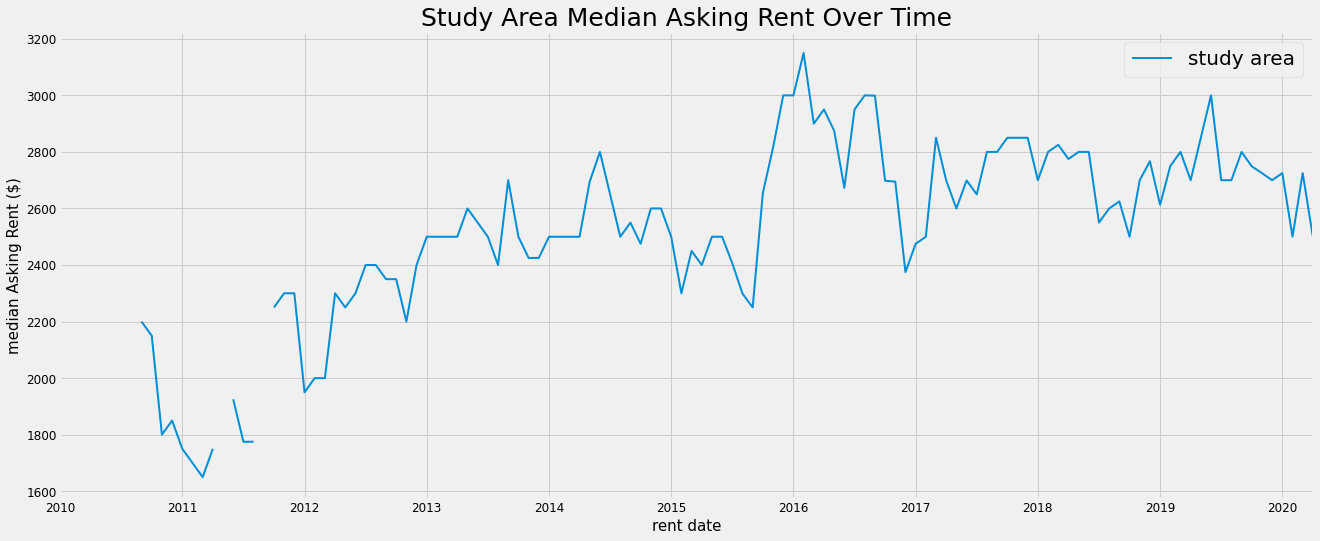

In [7]:
# Visulize the data 
f, ax = plt.subplots(figsize=(20,8))
time_means['median_rent_all'].plot(alpha=1,linewidth=2,ax=ax,label='study area')
plt.title("Study Area Median Asking Rent Over Time", fontsize=25)
plt.xlabel("rent date", fontsize=15)
plt.ylabel("median Asking Rent ($)", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

In [8]:
#Drop NA Values
time_means = time_means.dropna()

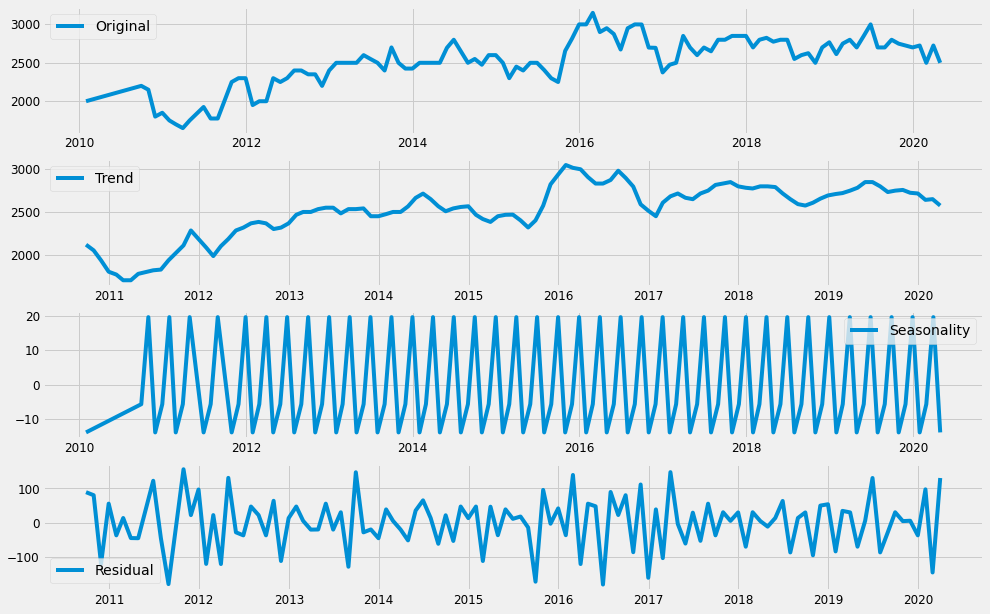

In [9]:
#Decomposing the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(time_means,freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(figsize=(15,10))
plt.subplot(411)
plt.plot(time_means, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.statespace as smstate

from statsmodels.graphics.api import qqplot

In [11]:
#Testing for stationarity
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_means.median_rent_all.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(time_means.median_rent_all.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.2867578883780117
p-value: 0.01548087388026646
Critial Values:
   1%, -3.4948504603223145
Critial Values:
   5%, -2.889758398668639
Critial Values:
   10%, -2.5818220155325444

KPSS Statistic: 0.701835
p-value: 0.013379
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [12]:
#Getting ARMA lags
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_means.median_rent_all,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2113.545852252886
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1778.9005294007375
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1459.5517400635085
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1272.0032918291354
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1469.558961349773
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1446.9845771322168
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1284.4270399350203
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1272.8738804701961
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1948.3852796861947
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1646.3985781282277
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1399.4784117989411
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1218.6847467703953
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1424.8742255650252
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1406.0464625316956
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1243.2001091962902
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1219.6499428008588
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1452.3490838126997
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1290.02324003

In [14]:
#Fitting the time series
import statsmodels.api as sm 
mod = sm.tsa.statespace.SARIMAX(time_means.median_rent_all,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    median_rent_all   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -572.410
Date:                            Wed, 15 Jul 2020   AIC                           1152.819
Time:                                    22:54:35   BIC                           1162.729
Sample:                                         0   HQIC                          1156.812
                                            - 115                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6116      0.157      3.907      0.000       0.305       0.918
ma.L1         -0.8682      0.118   

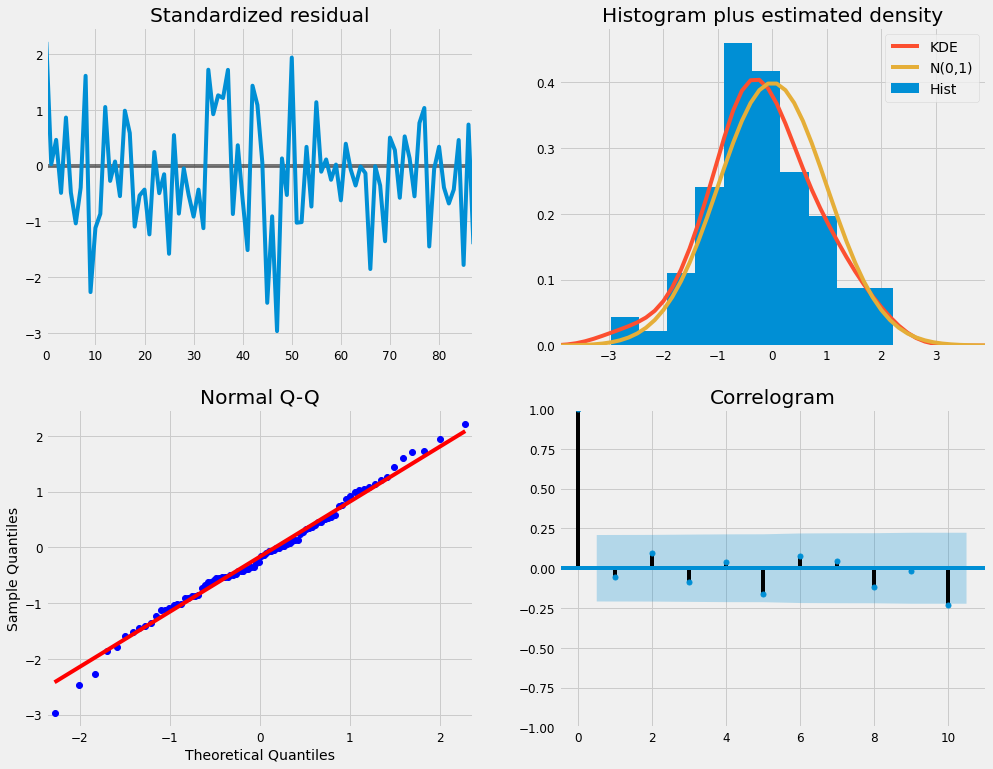

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
time_means

areaName,median_rent_all
index,
2010-01-31,2000.0
2010-09-30,2200.0
2010-10-31,2150.0
2010-11-30,1800.0
2010-12-31,1850.0
...,...
2019-12-31,2700.0
2020-01-31,2725.0
2020-02-29,2500.0


In [17]:
#Predicting the time-series
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()

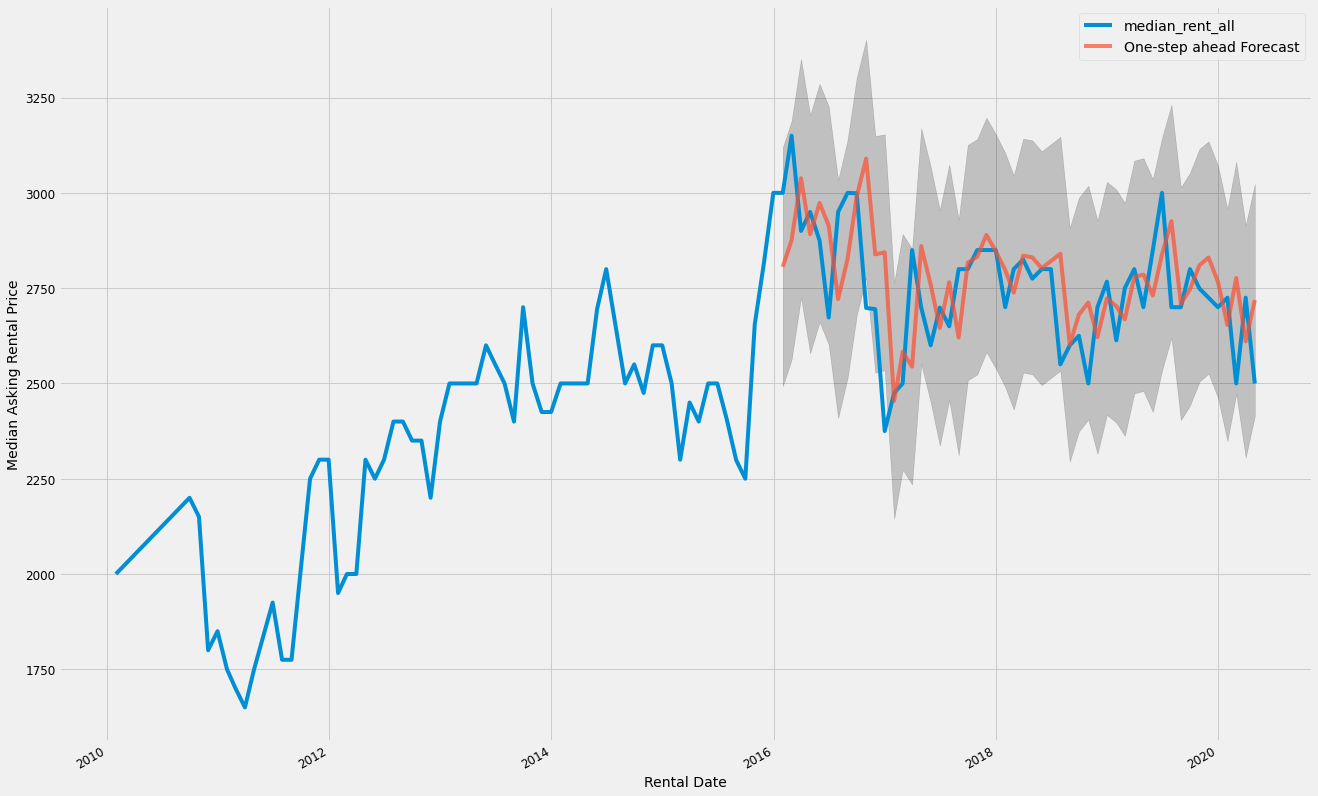

In [18]:
ax =time_means['2010':].plot(label='observed',figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Rental Date')
ax.set_ylabel('Median Asking Rental Price')
plt.legend()

plt.show()

In [19]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [20]:
pred_uc.predicted_mean.to_csv('median_rent_predictions_all_house_types_5&10Yrs')

In [ ]:
#5 Year Rent Increase - 18%
#10 Year Rent Increase - 24% 

Median Asking Rent - Three Plus Beds

###### Repeating steps from above

In [21]:
median_rent_threeplus = pd.read_csv('medianAskingRent_ThreePlusBd.csv')
median_rent_threeplus.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,...,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05
0,All Downtown,Manhattan,submarket,6700.0,6500.0,6500.0,6798.0,6798.0,6000.0,6000.0,6000.0,8300.0,7998.0,7950.0,7300.0,7500.0,7900.0,7500.0,6750.0,6750.0,7100.0,6725.0,7000.0,8000.0,9000.0,9000.0,8500.0,8500.0,7500.0,6991.0,6898.0,6750.0,6695.0,5850.0,6200.0,6900.0,6995.0,6648.0,6995.0,6500.0,...,6900.0,6500.0,6152.0,6250.0,6000.0,5950.0,5995.0,6200.0,6750.0,7000.0,7000.0,7350.0,7200.0,6875.0,6200.0,6313.0,5995.0,5911.0,6000.0,6000.0,6175.0,6798.0,6753.0,7495.0,6995.0,7098.0,6450.0,6450.0,6300.0,6300.0,6500.0,7086.0,7973.0,8878.0,9950.0,9700.0,8995.0,7900.0,6500.0,6146.0
1,All Midtown,Manhattan,submarket,7500.0,7900.0,6775.0,5795.0,6250.0,6500.0,7500.0,7500.0,7500.0,7650.0,7795.0,7850.0,7800.0,8000.0,7900.0,7295.0,7050.0,8500.0,8500.0,7850.0,8873.0,8000.0,7000.0,7250.0,8150.0,8498.0,8375.0,7500.0,8998.0,8900.0,7500.0,7050.0,7400.0,7000.0,7200.0,7100.0,6195.0,...,6900.0,6900.0,6500.0,6277.0,6200.0,6000.0,5995.0,6300.0,5795.0,6000.0,6300.0,6295.0,6263.0,6300.0,6100.0,5925.0,5785.0,5760.0,5795.0,5950.0,5883.0,5911.0,6038.0,6158.0,6398.0,5695.0,6095.0,5895.0,5895.0,6000.0,5995.0,6285.0,6500.0,6450.0,6985.0,6706.0,7000.0,6995.0,6480.0,5536.0
2,All Upper East Side,Manhattan,submarket,8925.0,8950.0,9850.0,8300.0,8050.0,7725.0,7500.0,7100.0,7648.0,7825.0,8500.0,7500.0,7663.0,8990.0,9500.0,9500.0,8950.0,8500.0,8550.0,8925.0,10000.0,9500.0,9500.0,9575.0,11000.0,9800.0,10995.0,10995.0,9775.0,9300.0,8995.0,8995.0,10600.0,9995.0,9575.0,10150.0,9950.0,...,9440.0,8995.0,9200.0,8250.0,7500.0,7495.0,7250.0,8250.0,7950.0,7600.0,7859.0,7550.0,8500.0,7999.0,8500.0,7850.0,7300.0,6798.0,6995.0,7995.0,8000.0,8495.0,9100.0,9298.0,8870.0,9263.0,8267.0,8495.0,7998.0,7000.0,7800.0,8995.0,9495.0,9500.0,9898.0,9500.0,12558.0,13995.0,11500.0,8445.0
3,All Upper Manhattan,Manhattan,submarket,2700.0,2673.0,2600.0,2795.0,2800.0,2600.0,2600.0,2700.0,2700.0,2600.0,2400.0,2400.0,2400.0,2500.0,2595.0,2750.0,2799.0,2800.0,3100.0,2845.0,3000.0,3000.0,2850.0,2875.0,2997.0,2900.0,2995.0,3195.0,3000.0,2800.0,2850.0,2800.0,2850.0,2900.0,2925.0,2850.0,2800.0,...,3000.0,3000.0,3162.0,3250.0,3250.0,3295.0,3200.0,3200.0,3073.0,2999.0,2996.0,2996.0,3000.0,3099.0,3195.0,3250.0,3295.0,3295.0,3300.0,3208.0,3025.0,3000.0,2999.0,3000.0,3000.0,3025.0,3195.0,3255.0,3300.0,3300.0,3300.0,3300.0,3254.0,3193.0,3195.0,3195.0,3200.0,3295.0,3350.0,3300.0
4,All Upper West Side,Manhattan,submarket,7000.0,7000.0,7000.0,7950.0,8998.0,8500.0,7250.0,7550.0,8000.0,8495.0,9000.0,8000.0,8500.0,8950.0,9000.0,8900.0,8495.0,8125.0,7950.0,7999.0,8400.0,8500.0,8950.0,8500.0,9000.0,8995.0,9500.0,9900.0,9000.0,9500.0,8900.0,8472.0,8500.0,8998.0,8995.0,9000.0,8500.0,...,8750.0,8525.0,8500.0,7500.0,7475.0,6995.0,6750.0,6950.0,6995.0,7000.0,7448.0,7242.0,7175.0,6995.0,7000.0,7000.0,6963.0,6000.0,6800.0,7000.0,7000.0,7950.0,7995.0,8095.0,7661.0,6919.0,6768.0,7000.0,6850.0,6400.0,6400.0,6500.0,7333.0,7950.0,8600.0,8898.0,8534.0,8248.0,7605.0,7000.0


In [22]:
df = median_rent_threeplus.melt(id_vars=["areaName", "Borough", "areaType"], 
        var_name="Date", 
        value_name="Value")
df = df.sort_values(['areaName', 'Date'])
df

,areaName,Borough,areaType,Date,Value
0,All Downtown,Manhattan,submarket,2010-01,6700.0
198,All Downtown,Manhattan,submarket,2010-02,6500.0
396,All Downtown,Manhattan,submarket,2010-03,6500.0
594,All Downtown,Manhattan,submarket,2010-04,6798.0
792,All Downtown,Manhattan,submarket,2010-05,6798.0
...,...,...,...,...,...
23957,Woodstock,Bronx,neighborhood,2020-01,NaN
24155,Woodstock,Bronx,neighborhood,2020-02,NaN
24353,Woodstock,Bronx,neighborhood,2020-03,NaN
24551,Woodstock,Bronx,neighborhood,2020-04,NaN


In [23]:
redhook1 = median_rent_threeplus.loc[median_rent_threeplus['areaName'] == 'Red Hook']
redhook2 = redhook1.dropna(axis=1,how="all")
redhook3=redhook2.drop(['Borough','areaType'], axis=1)
redhook4 = redhook3.set_index(['areaName'])
redhook= redhook4.T
redhook =redhook.rename(columns={'areaName': 'year', 'Red Hook': 'median_rent_threeplus'})
redhook = redhook.reset_index()
redhook['index'] =  pd.to_datetime(redhook['index'])
redhook = redhook.set_index(['index'])
redhook.head()

areaName,median_rent_threeplus
index,
2013-01-01,3000.0
2013-05-01,2600.0
2015-10-01,3550.0
2015-11-01,3393.0
2015-12-01,3300.0


In [24]:
time_means = redhook.resample('M').mean()
time_means

areaName,median_rent_threeplus
index,
2013-01-31,3000.0
2013-02-28,NaN
2013-03-31,NaN
2013-04-30,NaN
2013-05-31,2600.0
...,...
2019-07-31,NaN
2019-08-31,NaN
2019-09-30,NaN


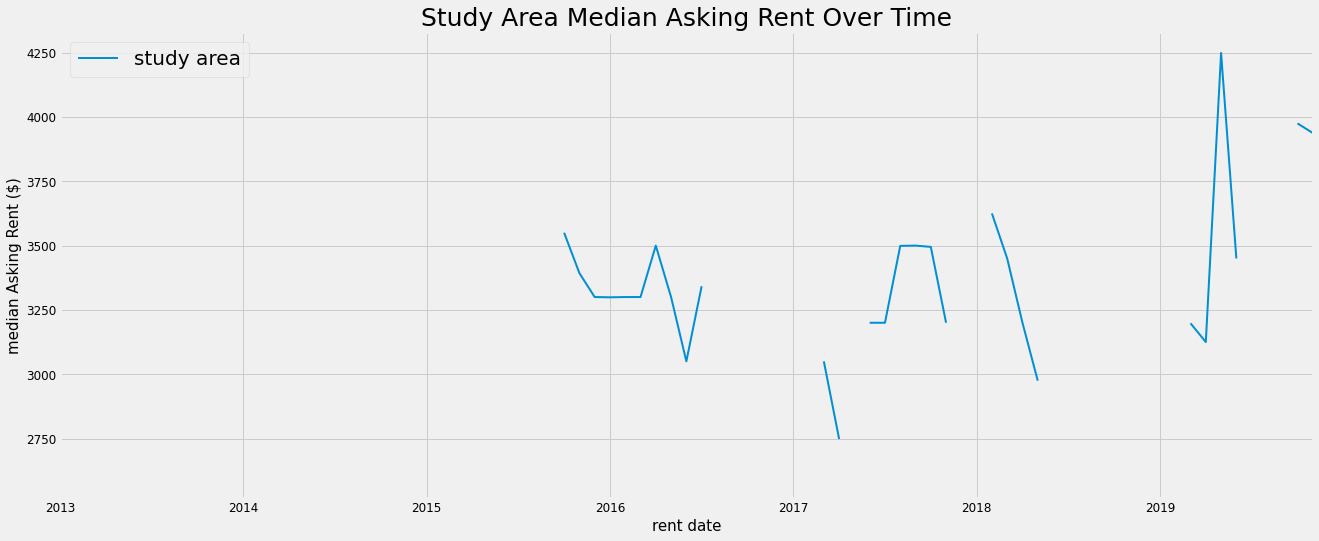

In [25]:
# Visulize the data 
f, ax = plt.subplots(figsize=(20,8))
time_means['median_rent_threeplus'].plot(alpha=1,linewidth=2,ax=ax,label='study area')
plt.title("Study Area Median Asking Rent Over Time", fontsize=25)
plt.xlabel("rent date", fontsize=15)
plt.ylabel("median Asking Rent ($)", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

In [26]:
time_means = time_means.dropna()

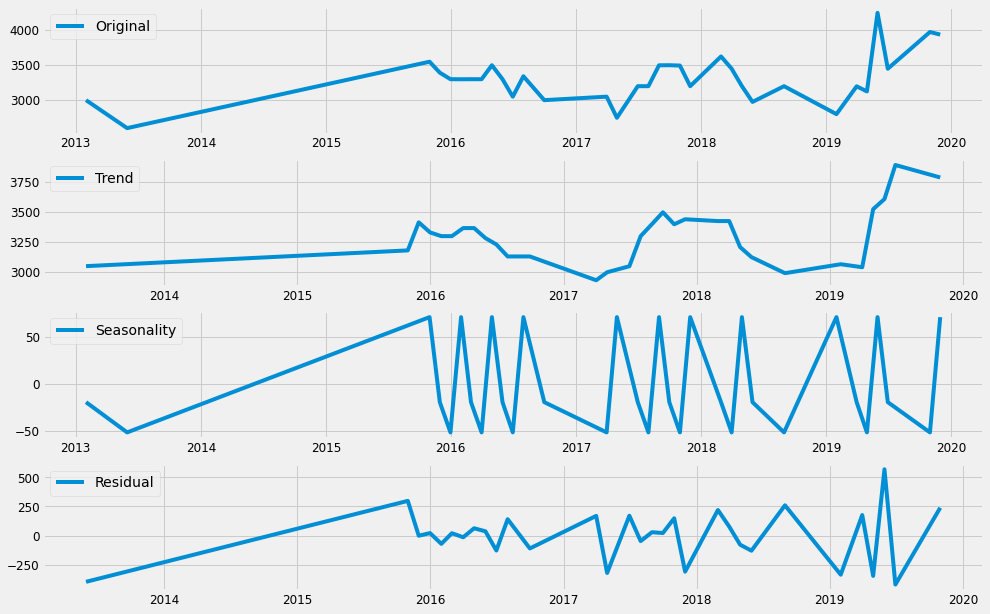

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(time_means,freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(figsize=(15,10))
plt.subplot(411)
plt.plot(time_means, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

In [28]:
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_means.median_rent_threeplus.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(time_means.median_rent_threeplus.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.3627076412918475
p-value: 0.15253964299950934
Critial Values:
   1%, -3.6889256286443146
Critial Values:
   5%, -2.9719894897959187
Critial Values:
   10%, -2.6252957653061224

KPSS Statistic: 0.435225
p-value: 0.061972
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [29]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_means.median_rent_threeplus,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:611.8945199134844
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:295.4451928770295
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:309.41215745683655
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:136.93606972296178
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:574.2856627806638
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:282.2952795488077
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:311.2769902982933
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:138.62695431946864
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:459.32736664038805
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:291.8832163604041
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:301.2416411154211
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:124.76689613947005
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:432.1593269563335
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:260.9862167243494
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:296.92820332486303
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:122.61383544768431
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:476.1363662203222
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:297.4414919999367
ARI

In [30]:
import statsmodels.api as sm 
mod = sm.tsa.statespace.SARIMAX(time_means.median_rent_threeplus,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:              median_rent_threeplus   No. Observations:                   33
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -51.659
Date:                            Wed, 15 Jul 2020   AIC                            109.319
Time:                                    22:57:38   BIC                            109.157
Sample:                                         0   HQIC                           107.313
                                             - 33                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6249      0.555     -1.126      0.260      -1.713       0.463
ar.S.L12      -0.0681      0.553   

ValueError: ignored

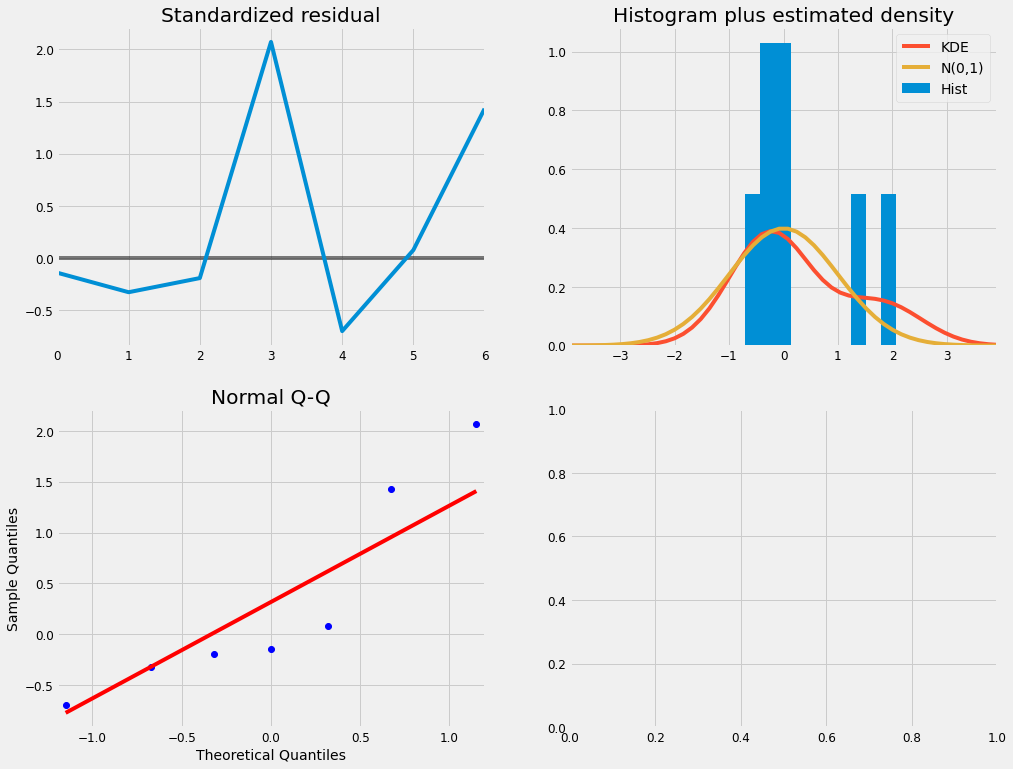

In [31]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [32]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()

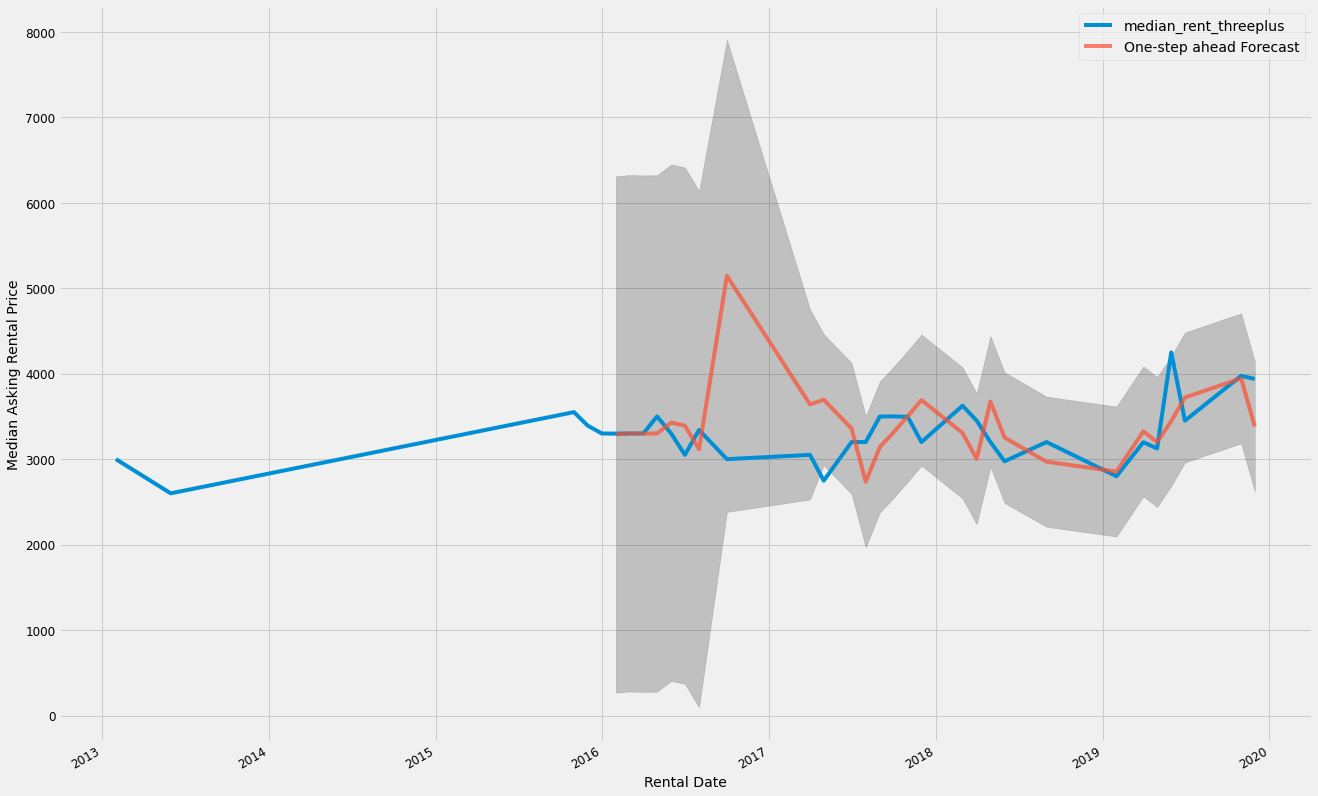

In [33]:
ax =time_means['2010':].plot(label='observed',figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Rental Date')
ax.set_ylabel('Median Asking Rental Price')
plt.legend()

plt.show()

In [34]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [36]:
pred_uc.predicted_mean.to_csv('median_rent_predictions_3+bed_5&10Yr')

Sales Price Analysis

In [ ]:
building_sales = pd.read_csv('combined_sales.csv')
building_sales.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,0,3,PARK SLOPE,22 STORE BUILDINGS,4,964,1,K5,275 4 AVENUE,11215.0,0,2,"10,000","1,500",1995.0,4,K5,0,2005-01-01
1,1,3,FLATBUSH-CENTRAL,29 COMMERCIAL GARAGES,4,5210,28,G5,1261 FLATBUSH AVENUE,11226.0,0,1,"1,664",900,1933.0,4,G5,0,2005-01-01
2,2,3,CROWN HEIGHTS,07 RENTALS - WALKUP APARTMENTS,2,1403,7,C7,1722 UNION STREET,11213.0,19,25,"5,300","18,216",1914.0,2,C7,0,2005-01-01
3,3,3,BOROUGH PARK,12 CONDOS - WALKUP APARTMENTS,2,5703,1402,R2,5813 11TH AVENUE,11219.0,1,1,0,0,0.0,2,R2,242182,2005-01-01
4,4,3,SHEEPSHEAD BAY,31 COMMERCIAL VACANT LAND,,7363,67,,3437 NOSTRAND AVENUE,11229.0,0,0,0,0,0.0,4,V1,0,2005-01-01


In [ ]:
building_sales = building_sales[building_sales['SALE PRICE'] != 0]
building_sales = building_sales.drop(columns=['Unnamed: 0'])
building_sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
3,3,BOROUGH PARK,12 CONDOS - WALKUP APARTMENTS,2,5703,1402,R2,5813 11TH AVENUE,11219.0,1,1,0,0,0.0,2,R2,242182,2005-01-01
34,3,FLATLANDS,10 COOPS - ELEVATOR APARTMENTS,2,7869,11,D4,"2239 TROY AVENUE, 1-C",11234.0,0,0,0,0,1953.0,2,D4,54000,2005-01-01
55,3,WILLIAMSBURG-SOUTH,13 CONDOS - ELEVATOR APARTMENTS,2,2137,1207,R4,407 BERRY STREET,11211.0,1,1,0,0,0.0,2,R4,182520,2005-01-02
60,3,BEDFORD STUYVESANT,02 TWO FAMILY HOMES,1,1788,63,B2,293 CLIFTON PLACE,11216.0,2,2,"2,250","5,086",1899.0,1,B2,500000,2005-01-02
64,3,EAST NEW YORK,02 TWO FAMILY HOMES,1,4231,24,B3,98 DOSCHER STREET,11208.0,2,2,"1,587","2,160",1910.0,1,B3,254400,2005-01-03


In [ ]:
building_sales['YEAR'] = pd.DatetimeIndex(building_sales['SALE DATE']).year

In [ ]:
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [ ]:
building_sales = building_sales.groupby(['ZIP CODE','SALE DATE'])
building_sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR
3,3,BOROUGH PARK,12 CONDOS - WALKUP APARTMENTS,2,5703,1402,R2,5813 11TH AVENUE,11219.0,1,1,0,0,0.0,2,R2,242182,2005-01-01,2005
34,3,FLATLANDS,10 COOPS - ELEVATOR APARTMENTS,2,7869,11,D4,"2239 TROY AVENUE, 1-C",11234.0,0,0,0,0,1953.0,2,D4,54000,2005-01-01,2005
55,3,WILLIAMSBURG-SOUTH,13 CONDOS - ELEVATOR APARTMENTS,2,2137,1207,R4,407 BERRY STREET,11211.0,1,1,0,0,0.0,2,R4,182520,2005-01-02,2005
60,3,BEDFORD STUYVESANT,02 TWO FAMILY HOMES,1,1788,63,B2,293 CLIFTON PLACE,11216.0,2,2,"2,250","5,086",1899.0,1,B2,500000,2005-01-02,2005
64,3,EAST NEW YORK,02 TWO FAMILY HOMES,1,4231,24,B3,98 DOSCHER STREET,11208.0,2,2,"1,587","2,160",1910.0,1,B3,254400,2005-01-03,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375493,3,BOERUM HILL,02 TWO FAMILY DWELLINGS,1,385,43,B9,160 HOYT STREET,11217.0,2,2,"1,600","3,040",1899.0,1,B9,2995000,2019-12-31,2019
375495,3,EAST NEW YORK,02 TWO FAMILY DWELLINGS,1,4024,27,B1,220 MILFORD STREET,11208.0,2,2,"3,000","1,643",1899.0,1,B1,590585,2019-12-31,2019
375496,3,OCEAN HILL,13 CONDOS - ELEVATOR APARTMENTS,2,1552,1007,R4,"1325 HERKIMER STREET, 205",11233.0,1,1,0,0,2018.0,2,R4,667773,2019-12-31,2019
375497,3,SUNSET PARK,21 OFFICE BUILDINGS,4,5794,14,O8,714 61ST STREET,11220.0,1,2,"1,717","2,295",1920.0,4,O8,2400000,2019-12-31,2019


In [ ]:
building_sales = building_sales.pivot_table(values=['SALE PRICE'],index=['BLOCK','LOT','ZIP CODE'],columns='YEAR').reset_index()
building_sales.head()

BLOCK   LOT ZIP CODE SALE PRICE       ...                               
YEAR                            2005 2006  ... 2015       2016 2017 2018 2019
0        1     1  11201.0        NaN  NaN  ...  NaN        NaN  NaN  NaN  NaN
1        1  1003  11201.0        NaN  NaN  ...  NaN  4147470.0  NaN  NaN  NaN
2        1  1004  11201.0        NaN  NaN  ...  NaN  4282212.0  NaN  NaN  NaN
3        1  1005  11201.0        NaN  NaN  ...  NaN  2336008.0  NaN  NaN  NaN
4        1  1006  11201.0        NaN  NaN  ...  NaN  3380173.0  NaN  NaN  NaN

[5 rows x 18 columns]

In [ ]:
building_sales.to_csv('building_grouped.csv')

In [ ]:
building_grouped = pd.read_csv('building_grouped.csv')
building_grouped.head()

,ID,BLOCK,LOT,ZIP CODE,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,1,1,11201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9200000.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1003,11201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4147470.0,NaN,NaN,NaN
2,2,1,1004,11201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4282212.0,NaN,NaN,NaN
3,3,1,1005,11201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2336008.0,NaN,NaN,NaN
4,4,1,1006,11201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3380173.0,NaN,NaN,NaN


In [ ]:
melt = building_grouped.melt(id_vars=['BLOCK','LOT','ZIP CODE'], var_name='Year', value_name='sale_price')

In [ ]:
melt

,ZIP CODE,Year,sale_price
0,11201.0,ID,0.0
1,11201.0,ID,1.0
2,11201.0,ID,2.0
3,11201.0,ID,3.0
4,11201.0,ID,4.0
...,...,...,...
2595145,0.0,2019,NaN
2595146,0.0,2019,NaN
2595147,11229.0,2019,645000.0
2595148,11229.0,2019,645000.0


In [ ]:
melt = building_sales.melt(id_vars=['BLOCK','LOT','ZIP CODE'], var_name='Year', value_name='sale_price')

#melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
#melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

#melt = melt.sort_values(['Week', 'Product_Code'])
#melt.head()

In [ ]:
melt = melt.sort_values(['BLOCK', 'LOT', 'ZIP CODE' ,'Year'])

In [ ]:
melt

,BLOCK,LOT,ZIP CODE,Year,sale_price
0,1,1,11201.0,SALE PRICE,NaN
144175,1,1,11201.0,SALE PRICE,NaN
288350,1,1,11201.0,SALE PRICE,NaN
432525,1,1,11201.0,SALE PRICE,NaN
576700,1,1,11201.0,SALE PRICE,NaN
...,...,...,...,...,...
1585924,8955,376,11229.0,SALE PRICE,NaN
1730099,8955,376,11229.0,SALE PRICE,NaN
1874274,8955,376,11229.0,SALE PRICE,NaN
2018449,8955,376,11229.0,SALE PRICE,NaN


In [ ]:
time_price = building_sales[['YEAR','SALE PRICE']]
df_time = time_price.set_index(['YEAR'])
df_time.head()

,SALE PRICE
YEAR,
2005,242182
2005,54000
2005,182520
2005,500000
2005,254400


In [ ]:
df_time

,SALE PRICE
YEAR,
2005,242182
2005,54000
2005,182520
2005,500000
2005,254400
...,...
2019,2995000
2019,590585
2019,667773


In [ ]:
df_time.index = pd.to_datetime(df_time.index, format='%Y')
time_price_means = pd.DataFrame(df_time.groupby('YEAR')['SALE PRICE'].apply(lambda x : x.astype(int).mean()))
time_price_means.head()

,SALE PRICE
YEAR,
2005-01-01,628156.768735
2006-01-01,706570.344721
2007-01-01,729269.177639
2008-01-01,722861.447193
2009-01-01,581800.177033


In [ ]:
import matplotlib.pyplot as plt

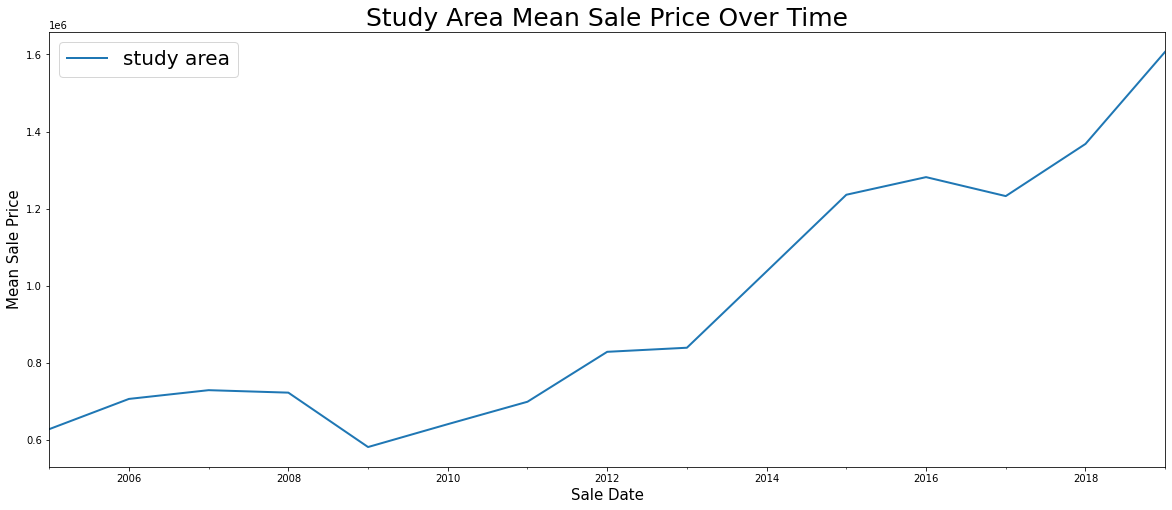

In [ ]:
# Visulize the data 

f, ax = plt.subplots(figsize=(20,8))
time_price_means ['SALE PRICE'].plot(alpha=1,linewidth=2,ax=ax,label='study area')
plt.title("Study Area Mean Sale Price Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Mean Sale Price", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


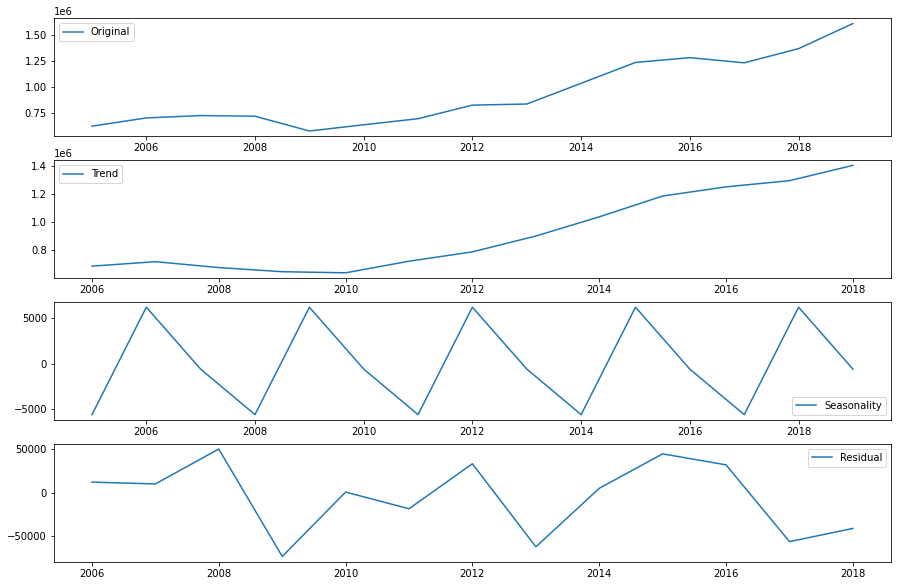

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(time_price_means,freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(figsize=(15,10))
plt.subplot(411)
plt.plot(time_price_means, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

In [ ]:
import pandas as pd 
import os
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
import matplotlib as mpl
import seaborn as sns
#import matplotlib.pylab as pl

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.statespace as smstate

from statsmodels.graphics.api import qqplot
import matplotlib.image as mpimg

In [ ]:
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_price_means['SALE PRICE'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(time_price_means['SALE PRICE'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.5945682112572632
p-value: 0.9874809768948498
Critial Values:
   1%, -4.473135048010974
Critial Values:
   5%, -3.28988060356653
Critial Values:
   10%, -2.7723823456790124

KPSS Statistic: 0.356467
p-value: 0.095919
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


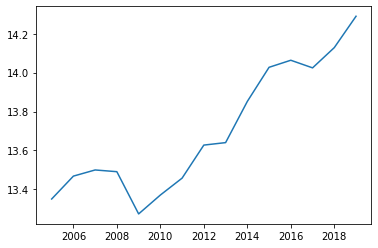

In [ ]:
price_log = np.log(time_price_means)
plt.plot(price_log)

In [ ]:
time_price_means['diff_price'] = time_price_means['SALE PRICE'] - time_price_means['SALE PRICE'].shift(6)
time_price_means_diff = time_price_means.dropna()
time_price_means_diff.head()

,SALE PRICE,diff_price
YEAR,,
2011-01-01,6.992730e+05,71116.270574
2012-01-01,8.287424e+05,122172.050959
2013-01-01,8.393322e+05,110063.005201
2014-01-01,1.037367e+06,314505.548157
2015-01-01,1.236092e+06,654291.668564


In [ ]:
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_price_means_diff.diff_price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.724950561732359
p-value: 0.4183052042484894
Critial Values:
   1%, -5.354256481481482
Critial Values:
   5%, -3.6462381481481483
Critial Values:
   10%, -2.901197777777778


In [ ]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_price_means.sale_price,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
import statsmodels.api as sm 
mod = sm.tsa.statespace.SARIMAX(time_price_means['SALE PRICE'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 3),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1820    1.2e+14   1.82e-14      1.000   -2.35e+14    2.35e+14
ma.L1         -2.1422   6.01e+10  -3.56e-11      1.000   -1.18e+11    1.18e+11
ma.S.L3     4.402e+14    2.3e+06   1.92e+08      0.000     4.4e+14     4.4e+14
sigma2      2.104e+10    2.4e+10      0.876      0.381    -2.6e+10    6.81e+10


In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [ ]:
time_price_means.shape

(15, 2)

In [ ]:
building_sales = building_sales.pivot_table(values=['SALE PRICE'],index=['BLOCK','LOT','ZIP CODE'],columns='YEAR').reset_index()
building_sales

BLOCK   LOT ZIP CODE SALE PRICE  ...                                        
YEAR                              2005  ...       2016     2017      2018      2019
0          1     1  11201.0        NaN  ...        NaN      NaN       NaN       NaN
1          1  1003  11201.0        NaN  ...  4147470.0      NaN       NaN       NaN
2          1  1004  11201.0        NaN  ...  4282212.0      NaN       NaN       NaN
3          1  1005  11201.0        NaN  ...  2336008.0      NaN       NaN       NaN
4          1  1006  11201.0        NaN  ...  3380173.0      NaN       NaN       NaN
...      ...   ...      ...        ...  ...        ...      ...       ...       ...
144170  8955   348      0.0        NaN  ...        NaN  53501.0       NaN       NaN
144171  8955   350      0.0        NaN  ...        NaN      NaN  105000.0       NaN
144172  8955   368  11229.0        NaN  ...        NaN      NaN       NaN  645000.0
144173  8955   370  11229.0        NaN  ...        NaN      NaN       NaN  645000.0
144174  8955   376  11229.0   578000.0  ...        NaN      NaN       NaN       NaN

[144175 rows x 18 columns]

In [ ]:
x = building_sales.dropna(thresh=10)
x.shape

BLOCK  LOT ZIP CODE  ...    SALE PRICE                            
YEAR                        ...          2017          2018          2019
1468      68  107  11201.0  ...  1.576667e+05  2.250000e+05  2.240000e+05
1471      86   11  11201.0  ...  5.297800e+05  5.335003e+05  5.475855e+05
2809     173   39  11217.0  ...  8.087767e+05  5.400000e+05  5.100000e+05
2917     178   25  11217.0  ...           NaN           NaN  8.850000e+05
2924     178   54  11217.0  ...  1.298600e+06  1.250000e+06  1.276250e+06
...      ...  ...      ...  ...           ...           ...           ...
143277  8819   11  11229.0  ...  1.839091e+05  1.871429e+05  1.938182e+05
143278  8820    1  11229.0  ...  1.633333e+05           NaN  1.450000e+05
143279  8820    7  11229.0  ...  1.516250e+05  1.291000e+05  1.766667e+05
143280  8821    1  11229.0  ...  1.623333e+05  2.026250e+05  2.034000e+05
143281  8821   10  11229.0  ...  1.541111e+05  1.600000e+05  2.061665e+05

[834 rows x 18 columns]

In [ ]:
x = building_sales.pivot_table(values=['SALE PRICE'],index=['BLOCK','LOT','ZIP CODE'],columns='YEAR').reset_index()
x.shape

(144175, 18)

In [ ]:
building_sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR
3,3,BOROUGH PARK,12 CONDOS - WALKUP APARTMENTS,2,5703,1402,R2,5813 11TH AVENUE,11219.0,1,1,0,0,0.0,2,R2,242182,2005-01-01,2005
34,3,FLATLANDS,10 COOPS - ELEVATOR APARTMENTS,2,7869,11,D4,"2239 TROY AVENUE, 1-C",11234.0,0,0,0,0,1953.0,2,D4,54000,2005-01-01,2005
55,3,WILLIAMSBURG-SOUTH,13 CONDOS - ELEVATOR APARTMENTS,2,2137,1207,R4,407 BERRY STREET,11211.0,1,1,0,0,0.0,2,R4,182520,2005-01-02,2005
60,3,BEDFORD STUYVESANT,02 TWO FAMILY HOMES,1,1788,63,B2,293 CLIFTON PLACE,11216.0,2,2,"2,250","5,086",1899.0,1,B2,500000,2005-01-02,2005
64,3,EAST NEW YORK,02 TWO FAMILY HOMES,1,4231,24,B3,98 DOSCHER STREET,11208.0,2,2,"1,587","2,160",1910.0,1,B3,254400,2005-01-03,2005
